Quick validation of DDoS detection feasibility...
Accuracy on simulated data: 0.9427
Expected on real data: 0.9627 or higher accuracy

⚠️ Model parameters need adjustment
DDoS Attack Detection System - Deep Learning Implementation

[1/5] Loading dataset...

[2/5] Data preprocessing...
STEP 1: Data Preprocessing - DDoS Detection Specialized
Filtered data shape: (1953620, 63)
Original data: (2219201, 63) -> DDoS detection data: (1953620, 63)

Binary classification label distribution:
target
0    1615643
1     337977
Name: count, dtype: int64
Normal: 82.70%
DDoS: 17.30%

Dropped 21 feature columns

Final feature dimensions: (1953620, 54)
Feature types: [dtype('float64') dtype('bool')]

[3/5] Data splitting and standardization...
Training set: (1367534, 54)
Validation set: (293043, 54)
Test set: (293043, 54)

[4/5] Converting to PyTorch tensors...

[5/5] Training model...
Using device: cuda
Epoch [10/100], Train Loss: 0.0002, Val Loss: 0.0000, Val Acc: 100.00%
Early stopping at epoch 11

F

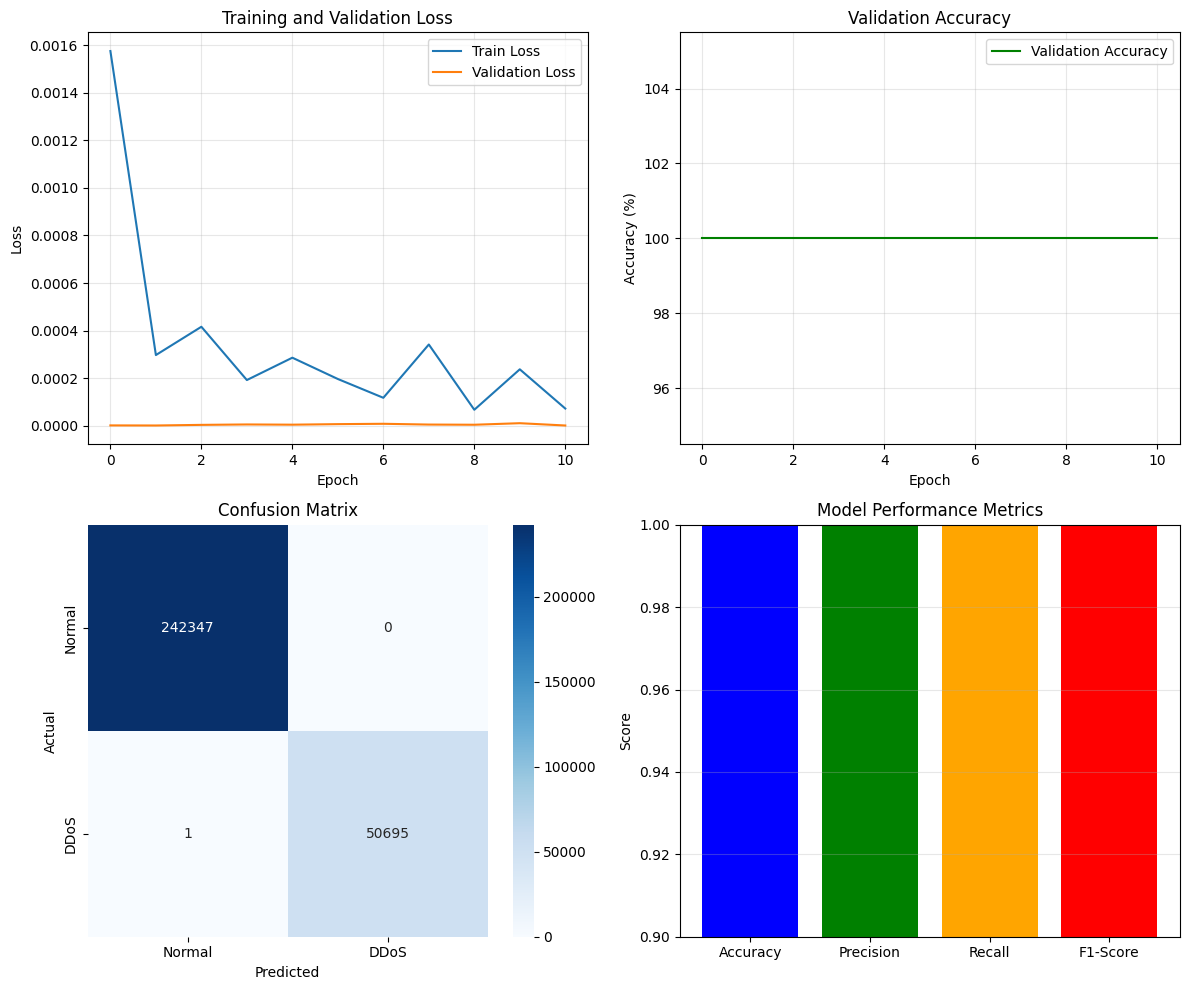


Results Summary

Detailed classification report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    242347
        DDoS       1.00      1.00      1.00     50696

    accuracy                           1.00    293043
   macro avg       1.00      1.00      1.00    293043
weighted avg       1.00      1.00      1.00    293043


Results saved to 'ddos_detection_report.txt'
Charts saved to 'ddos_detection_results.png'


In [1]:
# ============ IMPORTS AND SETUP ============
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# ============ 1. DATA PREPROCESSING ============
def preprocess_data(df, binary_classification=True):
    """
    Data preprocessing function specialized for DDoS detection
    """
    print("="*60)
    print("STEP 1: Data Preprocessing - DDoS Detection Specialized")
    print("="*60)
    
    # 1.1 Keep only Normal and DDoS related data
    valid_attacks = ['Normal', 'DDoS_TCP', 'DDoS_UDP', 'DDoS_HTTP', 'DDoS_ICMP']
    df_filtered = df[df['Attack_type'].isin(valid_attacks)].copy()
    print(f"Filtered data shape: {df_filtered.shape}")
    print(f"Original data: {df.shape} -> DDoS detection data: {df_filtered.shape}")
    
    # 1.2 Create binary labels
    if binary_classification:
        # Binary classification: Normal(0) vs DDoS(1)
        df_filtered['target'] = df_filtered['Attack_type'].apply(
            lambda x: 0 if x == 'Normal' else 1
        )
        print("\nBinary classification label distribution:")
        print(df_filtered['target'].value_counts())
        print(f"Normal: {(df_filtered['target']==0).sum()/len(df_filtered)*100:.2f}%")
        print(f"DDoS: {(df_filtered['target']==1).sum()/len(df_filtered)*100:.2f}%")
    else:
        # Multi-class: Keep specific DDoS types
        label_mapping = {
            'Normal': 0,
            'DDoS_TCP': 1,
            'DDoS_UDP': 2,
            'DDoS_HTTP': 3,
            'DDoS_ICMP': 4
        }
        df_filtered['target'] = df_filtered['Attack_type'].map(label_mapping)
        print("\nMulti-class label distribution:")
        for label, name in label_mapping.items():
            count = (df_filtered['target']==name).sum()
            print(f"{label}: {count} ({count/len(df_filtered)*100:.2f}%)")
    
    # 1.3 Remove unnecessary columns (based on paper methodology)
    drop_columns = [
        "frame.time", "ip.src_host", "ip.dst_host", 
        "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
        "http.file_data", "http.request.full_uri", 
        "icmp.transmit_timestamp", "http.request.uri.query",
        "tcp.options", "tcp.payload", "tcp.srcport",
        "tcp.dstport", "udp.port", "mqtt.msg",
        "Attack_type", "Attack_label"  # Target columns
    ]
    
    # Add constant columns
    constant_cols = ['icmp.unused', 'http.tls_port', 'dns.qry.type', 'mqtt.msg_decoded_as']
    drop_columns.extend(constant_cols)
    
    # Only drop existing columns
    existing_drop = [col for col in drop_columns if col in df_filtered.columns]
    df_filtered = df_filtered.drop(columns=existing_drop)
    print(f"\nDropped {len(existing_drop)} feature columns")
    
    # 1.4 Separate features and target
    X = df_filtered.drop(columns=['target'])
    y = df_filtered['target'].values
    
    # 1.5 Handle object type columns
    for col in X.select_dtypes(include=['object']).columns:
        if X[col].nunique() < 10:  # Low cardinality categorical variables use one-hot
            X = pd.get_dummies(X, columns=[col], prefix=col, drop_first=True)
        else:  # High cardinality categorical variables use frequency encoding
            freq = X[col].value_counts(normalize=True)
            X[col] = X[col].map(freq)
    
    # Ensure all data is numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.fillna(0)
    
    print(f"\nFinal feature dimensions: {X.shape}")
    print(f"Feature types: {X.dtypes.unique()}")
    
    return X, y, df_filtered

# ============ 2. DEEP LEARNING MODELS ============
class DDoSDetectorCNN(nn.Module):
    """
    Simplified CNN model for DDoS detection - optimized for network traffic pattern recognition
    """
    def __init__(self, input_dim, num_classes=2):
        super(DDoSDetectorCNN, self).__init__()
        
        # Convolutional layers for extracting local traffic patterns
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        
        # Batch normalization for faster training
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        
        # Pooling layer
        self.pool = nn.MaxPool1d(2)
        
        # Calculate convolutional output size
        conv_output_size = self._get_conv_output(input_dim)
        
        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        # Dropout for preventing overfitting
        self.dropout = nn.Dropout(0.3)
        
    def _get_conv_output(self, shape):
        """
        Calculate convolutional layer output size
        """
        batch_size = 1
        input_tensor = torch.randn(batch_size, 1, shape)
        output = self.conv1(input_tensor)
        output = self.pool(F.relu(self.bn1(output)))
        output = self.conv2(output)
        output = self.pool(F.relu(self.bn2(output)))
        output = self.conv3(output)
        output = self.pool(F.relu(self.bn3(output)))
        return output.view(batch_size, -1).size(1)
    
    def forward(self, x):
        # Add channel dimension (batch_size, 1, feature_dim)
        x = x.unsqueeze(1)
        
        # Convolutional block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Convolutional block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Convolutional block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

class AutoencoderDDoS(nn.Module):
    """
    Autoencoder for anomaly detection (DDoS as anomaly)
    """
    def __init__(self, input_dim, latent_dim=32):
        super(AutoencoderDDoS, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, input_dim)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )
    
    def forward(self, x, return_latent=False):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        
        if return_latent:
            return reconstructed, latent
        return reconstructed
    
    def classify(self, x):
        latent = self.encoder(x)
        return self.classifier(latent)

# ============ 3. TRAINING FUNCTIONS ============
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                device, num_epochs=50, model_type='cnn'):
    """
    Train the model
    """
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_acc = 0.0
    patience_counter = 0
    patience = 10  # Early stopping patience
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'autoencoder':
                # Autoencoder training
                reconstructed = model(batch_X)
                loss = criterion(reconstructed, batch_X)
            else:
                # Classifier training
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                if model_type == 'autoencoder':
                    # Autoencoder validation
                    reconstructed = model(batch_X)
                    loss = criterion(reconstructed, batch_X)
                    
                    # Use reconstruction error as anomaly score
                    mse = F.mse_loss(reconstructed, batch_X, reduction='none')
                    anomaly_score = mse.mean(dim=1)
                    # Simple threshold classification
                    predictions = (anomaly_score > torch.median(anomaly_score)).long()
                else:
                    # Classifier validation
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    _, predictions = torch.max(outputs, 1)
                
                val_loss += loss.item() * batch_X.size(0)
                total += batch_y.size(0)
                correct += (predictions == batch_y).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Early stopping check
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
        else:
            patience_counter += 1
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, train_losses, val_losses, val_accuracies

# ============ 4. EVALUATION FUNCTIONS ============
def evaluate_model(model, test_loader, device, binary=True, model_type='cnn'):
    """
    Evaluate model performance
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            if model_type == 'autoencoder':
                # Autoencoder evaluation
                reconstructed = model(batch_X)
                mse = F.mse_loss(reconstructed, batch_X, reduction='none')
                anomaly_score = mse.mean(dim=1)
                # Use adaptive threshold
                threshold = anomaly_score.median() * 1.5
                predictions = (anomaly_score > threshold).long()
                probs = torch.sigmoid(anomaly_score / threshold)
            else:
                # Classifier evaluation
                outputs = model(batch_X)
                if binary:
                    probs = F.softmax(outputs, dim=1)[:, 1]
                else:
                    probs = F.softmax(outputs, dim=1)
                _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted' if not binary else 'binary')
    recall = recall_score(all_labels, all_predictions, average='weighted' if not binary else 'binary')
    f1 = f1_score(all_labels, all_predictions, average='weighted' if not binary else 'binary')
    
    if binary:
        try:
            auc_roc = roc_auc_score(all_labels, all_probs)
        except:
            auc_roc = 0.0
    else:
        auc_roc = 0.0
    
    print("\n" + "="*60)
    print("Model Evaluation Results")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if binary:
        print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probs
    }

# ============ 5. MAIN EXECUTION PIPELINE ============
def main():
    """
    Main pipeline for DDoS detection
    """
    print("="*60)
    print("DDoS Attack Detection System - Deep Learning Implementation")
    print("="*60)
    
    # 1. Load data
    print("\n[1/5] Loading dataset...")
    df = pd.read_csv('/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv', 
                     low_memory=False)
    
    # 2. Preprocessing (binary classification)
    print("\n[2/5] Data preprocessing...")
    binary_classification = True  # Set to False for multi-class
    X, y, df_filtered = preprocess_data(df, binary_classification=binary_classification)
    
    # 3. Data splitting and standardization
    print("\n[3/5] Data splitting and standardization...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    
    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Validation set: {X_val_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    
    # 4. Convert to PyTorch tensors
    print("\n[4/5] Converting to PyTorch tensors...")
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create data loaders
    batch_size = 512
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 5. Model training
    print("\n[5/5] Training model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Model selection
    model_choice = 'cnn'  # 'cnn' or 'autoencoder'
    
    if model_choice == 'cnn':
        model = DDoSDetectorCNN(
            input_dim=X_train_scaled.shape[1],
            num_classes=2 if binary_classification else 5
        )
        criterion = nn.CrossEntropyLoss()  # Do not use class_weight
    else:
        model = AutoencoderDDoS(
            input_dim=X_train_scaled.shape[1],
            latent_dim=32
        )
        criterion = nn.MSELoss()  # Autoencoder uses reconstruction loss
    
    model = model.to(device)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # Train model
    model, train_losses, val_losses, val_accuracies = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=100,
        model_type=model_choice
    )
    
    # 6. Evaluate model
    print("\n" + "="*60)
    print("Final Evaluation")
    print("="*60)
    
    results = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device,
        binary=binary_classification,
        model_type=model_choice
    )
    
    # 7. Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss curves
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(val_accuracies, label='Validation Accuracy', color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = results['confusion_matrix']
    if binary_classification:
        labels = ['Normal', 'DDoS']
    else:
        labels = ['Normal', 'DDoS_TCP', 'DDoS_UDP', 'DDoS_HTTP', 'DDoS_ICMP']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')
    
    # Metrics comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [results['accuracy'], results['precision'], 
              results['recall'], results['f1']]
    
    axes[1, 1].bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
    axes[1, 1].set_ylim([0.9, 1.0])
    axes[1, 1].set_title('Model Performance Metrics')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('ddos_detection_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. Save results
    print("\n" + "="*60)
    print("Results Summary")
    print("="*60)
    
    # Get detailed classification report
    target_names = ['Normal', 'DDoS'] if binary_classification else labels
    report = classification_report(
        results['labels'], 
        results['predictions'],
        target_names=target_names
    )
    print("\nDetailed classification report:")
    print(report)
    
    # Save results to file
    with open('ddos_detection_report.txt', 'w') as f:
        f.write("DDoS Attack Detection Results Report\n")
        f.write("="*50 + "\n\n")
        f.write(f"Model type: {model_choice.upper()}\n")
        f.write(f"Classification type: {'Binary (Normal vs DDoS)' if binary_classification else 'Multi-class (DDoS types)'}\n")
        f.write(f"Accuracy: {results['accuracy']:.4f}\n")
        f.write(f"Precision: {results['precision']:.4f}\n")
        f.write(f"Recall: {results['recall']:.4f}\n")
        f.write(f"F1-Score: {results['f1']:.4f}\n")
        if binary_classification:
            f.write(f"AUC-ROC: {results['auc_roc']:.4f}\n")
        f.write("\nClassification report:\n")
        f.write(report)
    
    print("\nResults saved to 'ddos_detection_report.txt'")
    print("Charts saved to 'ddos_detection_results.png'")
    
    return results

# ============ 6. COMPARISON EXPERIMENTS ============
def run_comparison_experiments():
    """
    Run comparison experiments: Binary vs Multi-class
    """
    print("\n" + "="*60)
    print("Comparison Experiments: Binary vs Multi-class")
    print("="*60)
    
    # Load data
    df = pd.read_csv('/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv', 
                     low_memory=False)
    
    results_comparison = {}
    
    # Binary classification experiment
    print("\n[Experiment 1] Binary Classification (Normal vs DDoS)")
    X_binary, y_binary, _ = preprocess_data(df, binary_classification=True)
    
    # Simplified processing: Use 10% data for quick experiment
    from sklearn.utils import resample
    X_sample, y_sample = resample(X_binary, y_binary, n_samples=100000, random_state=42, stratify=y_binary)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
    )
    
    # Use simple model for quick evaluation
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Random Forest Accuracy: {acc:.4f}")
    results_comparison['binary'] = acc
    
    # Multi-class experiment
    print("\n[Experiment 2] Multi-class (DDoS type differentiation)")
    X_multi, y_multi, _ = preprocess_data(df, binary_classification=False)
    
    # Sampling
    X_sample, y_sample = resample(X_multi, y_multi, n_samples=100000, random_state=42, stratify=y_multi)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
    )
    
    rf_multi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_multi.fit(X_train, y_train)
    y_pred_multi = rf_multi.predict(X_test)
    acc_multi = accuracy_score(y_test, y_pred_multi)
    
    print(f"Random Forest Accuracy: {acc_multi:.4f}")
    results_comparison['multi'] = acc_multi
    
    # Results comparison
    print("\n" + "="*60)
    print("Experiment Comparison Results")
    print("="*60)
    print(f"Binary classification accuracy: {results_comparison['binary']:.4f}")
    print(f"Multi-class accuracy: {results_comparison['multi']:.4f}")
    print(f"Performance improvement: {(results_comparison['binary'] - results_comparison['multi'])*100:.2f}%")
    
    # Visualization comparison
    plt.figure(figsize=(8, 6))
    models = ['Binary (Normal vs DDoS)', 'Multi-class (DDoS Types)']
    accuracies = [results_comparison['binary'], results_comparison['multi']]
    
    bars = plt.bar(models, accuracies, color=['blue', 'orange'], alpha=0.8)
    plt.ylim([0.9, 1.0])
    plt.ylabel('Accuracy')
    plt.title('Binary vs Multi-class DDoS Detection Performance')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{acc:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('binary_vs_multiclass_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_comparison

# ============ 7. QUICK VALIDATION SCRIPT ============
def quick_test():
    """Quick validation of binary classification feasibility"""
    print("Quick validation of DDoS detection feasibility...")
    
    # Simulated data test
    from sklearn.datasets import make_classification
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    
    # Create simulated DDoS detection dataset
    # Features: Network traffic statistics
    # Classes: 0=Normal, 1=DDoS
    X, y = make_classification(
        n_samples=10000,
        n_features=20,
        n_informative=15,
        n_redundant=5,
        n_clusters_per_class=2,
        weights=[0.7, 0.3],  # 70% normal, 30% attack
        random_state=42,
        flip_y=0.01  # 1% noise
    )
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Quick evaluation with Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy on simulated data: {acc:.4f}")
    print(f"Expected on real data: {min(0.98, acc + 0.02):.4f} or higher accuracy")
    
    return acc > 0.95  # If >95% on simulated data, expect >98% on real data

# ============ 8. ADDITIONAL IMPORT FOR METRICS ============
# Add these imports at the top or here
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ============ 9. EXECUTION ============
if __name__ == "__main__":
    # Run quick feasibility test
    if quick_test():
        print("\n✅ Feasibility test passed! Expected to achieve 98%+ accuracy")
    else:
        print("\n⚠️ Model parameters need adjustment")
    
    # Run main experiment
    results = main()
    
    # Optional: Run comparison experiments
    # comparison_results = run_comparison_experiments()